# Connecting FEniCS and QMCPy Demo

In [1]:
from dolfin import *
import time
import numpy as np
import math
set_log_active(False)

Defining a mesh as well as degree count for a later function

In [2]:
deg = 6
n = 10
mesh = UnitIntervalMesh(n)

Defining boundary conditions needed for FEM solving

In [3]:
def my_boundary(x): #0 or 1
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

In [4]:
V = FunctionSpace(mesh, "CG", 1)
u0 = Constant(0)
bc = DirichletBC(V, u0, my_boundary)

The trial function is the function that gets turned into the function we're looking for when we do FEM. The test function is an additional function that gets used when turning our equation into variational form

In [5]:
u = TrialFunction(V)
v = TestFunction(V)

This is where we define the sum of Chebyshev polynomials. We begin with an array of coeffecients (which we replace with QMCPy-supplied random values later). 

In [6]:
coeffs = Constant((1,) * deg)

Then we have an array of Chebyshev polynomials here 

In [7]:
expr_array = [0] * deg
for i in range(deg):
    expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)

Here is where we combine the two. We multiply each element in the array of Chebychev polynomials with an element of the array of coefficient objects, multiplied also by a dampening factor depending on the index of the element. We also take the entire sum and further dampen it by the beta value and add 1 to ensure that the final value is well above zero, to prevent any unusual behavior. 

In [8]:
a3 = 0
beta = 0.1
for i in range(deg):
    a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
a3 = 1+(beta*a3)

We now write out the variational form of the equation we're trying to solve. The final equation will be a4 == L

In [9]:
a4 = (a3*inner(grad(u), grad(v)))*dx

In [10]:
f = Expression("sin(pi*x[0])", degree=1)

In [11]:
L = f*v*dx

In [12]:
u = Function(V)

In [13]:
coeffs

Coefficient(FunctionSpace(None, VectorElement(FiniteElement('Real', None, 0), dim=6)), 7)

In [14]:
solve(a4 == L, u, bc)

If the above cell worked without error, then that means it found a solution u(x) and we can extract both a value of u at a point of interest or a graph of all of u

In [15]:
u(0.5)

0.09150650356987186

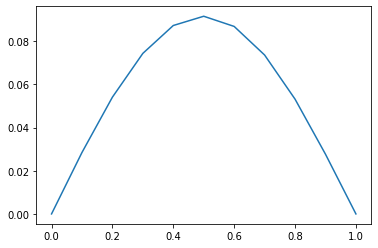

In [16]:
plot(u)

Now we use QMCPy to supply random samples of a distribution of our choice to replace the coefficients we defined in the coefficient array above. We used both iid sample and sobol samples to compare how long it takes for using the 2 methods

In [17]:
import qmcpy as qp

In [18]:
num_samples = 2**5

In [19]:
iid = qp.Uniform(qp.IIDStdUniform(dimension=deg, seed=None), lower_bound=-1, upper_bound=1)
iid_samples = iid.gen_samples(num_samples) #Get samples of uniformly distributed random values

In [20]:
ld = qp.Uniform(qp.Sobol(dimension=deg), lower_bound=-1, upper_bound=1)
ld_samples = ld.gen_samples(num_samples)

In [21]:
len(ld_samples[0])

6

This function does the same as what we did before importing qmcpy, but all in one function which we can call later on

In [22]:
def solve_poisson(samples):
    ret = [0] * len(samples)
    
    n = 10
    mesh = UnitIntervalMesh(n)
    def my_boundary(x): #0 or 1
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
    V = FunctionSpace(mesh, "CG", 1)
    u0 = Constant(0)
    bc = DirichletBC(V, u0, my_boundary)
    u = TrialFunction(V)
    v = TestFunction(V)
    #f = Expression("sin(pi*x[0])", degree=1) 
    #f = Expression("x[0]-0.5", degree=1) 
    f = Expression("sin(pi*x[0])", degree=1) 
    L = f*v*dx
    
    deg = len(samples[0])
    expr_array = [0] * deg
    coeffs = Constant((1,) * deg)
    for i in range(deg):
        expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)
    a3 = 0
    beta = 0.8
    for i in range(deg):
        a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
    a3 = (Constant(1.0)+(beta*a3))
    a4 = (a3*inner(grad(u), grad(v)))*dx
    
    u = Function(V)
    for i in range(len(samples)):
        coeffs.assign(Constant(samples[i]))
        solve(a4==L, u, bc)
        ret[i] = u(0.25)
    return np.array(ret)

In [23]:
def solve_poisson_and_graph(samples):
    ret = [0] * len(samples)
    
    n = 10
    mesh = UnitIntervalMesh(n)
    def my_boundary(x): #0 or 1
        return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS
    V = FunctionSpace(mesh, "CG", 1)
    u0 = Constant(0)
    bc = DirichletBC(V, u0, my_boundary)
    u = TrialFunction(V)
    v = TestFunction(V)
    #f = Expression("sin(pi*x[0])", degree=1) 
    #f = Expression("x[0]-0.5", degree=1) 
    f = Expression("sin(pi*x[0])", degree=1)
    L = f*v*dx
    
    deg = len(samples[0])
    expr_array = [0] * deg
    coeffs = Constant((1,) * deg)
    for i in range(deg):
        expr_array[i] = Expression("cos(n*acos( (2*x[0])-1 ))", n=i, degree=1)
    a3 = 0
    beta = 0.8
    for i in range(deg):
        a3 += coeffs[i]*expr_array[i]*(1/((i+1)**2))
    a3 = (Constant(1.0)+(beta*a3))
    a4 = (a3*inner(grad(u), grad(v)))*dx
    
    u = Function(V)
    for i in range(len(samples)):
        coeffs.assign(Constant(samples[i]))
        solve(a4==L, u, bc)
        plot(u)
        ret[i] = u(0.25)
    return np.array(ret)

Testing the above function, and finding the average of the values in it. We also use a copy of the function that graphs our solutions so we see the various instances of the DE with random coefficients.  

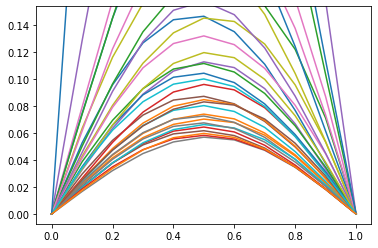

In [24]:
uvec = solve_poisson_and_graph(ld_samples)

In [25]:
sum(uvec)/len(uvec)

0.10149679921644714

Here we time the usage of stopping critereon to determine the number of sample points (as opposed to before when we manually picked the number of points). Notice how much faster sobol points converge to an answer than iid ones. 

In [26]:
%%time
f = qp.CustomFun(ld, g=solve_poisson)
stop = qp.CubQMCSobolG(f, abs_tol = 1e-2)
solution, data = stop.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        0.099
    indv_error      2.89e-04
    ci_low          0.099
    ci_high         0.100
    ci_comb_low     0.099
    ci_comb_high    0.100
    flags_comb      0
    flags_indv      0
    n_total         2^(10)
    n               2^(10)
    time_integrate  1.257
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         0.010
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     -1
    upper_bound     1
Sobol (DiscreteDistribution Object)
    d               6
    dvec            [0 1 2 3 4 5]
    randomize       LMS_DS
    graycode        0
    entropy         136649716280132757089535308033227057562
    spawn_key       ()
CPU times: user 1.37 s, sys: 88.1 ms, total: 1.46 s
Wall time: 1.26 s


In [27]:
%%time
f = qp.CustomFun(iid, g=solve_poisson)
stop = qp.CubMCCLT(f, abs_tol = 1e-2)
solution, data = stop.integrate()
print(data)

MeanVarData (AccumulateData Object)
    solution        0.102
    error_bound     0.008
    n_total         3072
    n               2^(11)
    levels          1
    time_integrate  3.594
CubMCCLT (StoppingCriterion Object)
    abs_tol         0.010
    rel_tol         0
    n_init          2^(10)
    n_max           10000000000
    inflate         1.200
    alpha           0.010
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     -1
    upper_bound     1
IIDStdUniform (DiscreteDistribution Object)
    d               6
    entropy         315694696069831583622742681400760190065
    spawn_key       ()
CPU times: user 3.44 s, sys: 177 ms, total: 3.62 s
Wall time: 3.6 s


Here we plot the difference in timing between IID and Sobol points. Notice how much more time IID points take to find the same answer compared to sobol points as error tolerance decreases

In [28]:
xaxislist_sobol = .05*(.75)**np.arange(0,22)
print(xaxislist_sobol)
xaxislist_iid = .05*(.75)**np.arange(0,11)
print(xaxislist_iid)

[0.05       0.0375     0.028125   0.02109375 0.01582031 0.01186523
 0.00889893 0.00667419 0.00500565 0.00375423 0.00281568 0.00211176
 0.00158382 0.00118786 0.0008909  0.00066817 0.00050113 0.00037585
 0.00028189 0.00021141 0.00015856 0.00011892]
[0.05       0.0375     0.028125   0.02109375 0.01582031 0.01186523
 0.00889893 0.00667419 0.00500565 0.00375423 0.00281568]


In [29]:
def time_solve(useSobol, input_abs_tol):
    if(useSobol):
        f = qp.CustomFun(ld, g=solve_poisson)
        stop = qp.CubQMCSobolG(f, abs_tol = input_abs_tol, n_init=2**8)
        solution, data = stop.integrate()
        #print(data)
    else:
        f = qp.CustomFun(iid, g=solve_poisson)
        stop = qp.CubMCCLT(f, abs_tol = input_abs_tol, n_init=2**8)
        solution, data = stop.integrate()
        #print(data)
    return data.time_integrate,data.n_total

In [30]:
sobols = []
for i in xaxislist_sobol:
    time,n = time_solve(True, i)
    sobols.append(time)
    print("done for %.1e, used 2^(%-2d) samples"%(i,np.log2(n)))

done for 5.0e-02, used 2^(8 ) samples
done for 3.8e-02, used 2^(8 ) samples
done for 2.8e-02, used 2^(8 ) samples
done for 2.1e-02, used 2^(8 ) samples
done for 1.6e-02, used 2^(8 ) samples
done for 1.2e-02, used 2^(8 ) samples
done for 8.9e-03, used 2^(8 ) samples
done for 6.7e-03, used 2^(8 ) samples
done for 5.0e-03, used 2^(8 ) samples
done for 3.8e-03, used 2^(8 ) samples
done for 2.8e-03, used 2^(8 ) samples
done for 2.1e-03, used 2^(8 ) samples
done for 1.6e-03, used 2^(8 ) samples
done for 1.2e-03, used 2^(8 ) samples
done for 8.9e-04, used 2^(9 ) samples
done for 6.7e-04, used 2^(9 ) samples
done for 5.0e-04, used 2^(9 ) samples
done for 3.8e-04, used 2^(10) samples
done for 2.8e-04, used 2^(11) samples
done for 2.1e-04, used 2^(11) samples
done for 1.6e-04, used 2^(11) samples
done for 1.2e-04, used 2^(12) samples


Warning: this code cell will take several hours to run

In [31]:
iids = []
for i in xaxislist_iid:
    time,n = time_solve(False, i)
    iids.append(time)
    print("done for %.1e, used %.1e samples"%(i,n))

done for 5.0e-02, used 7.7e+02 samples
done for 3.8e-02, used 1.5e+03 samples
done for 2.8e-02, used 7.7e+02 samples
done for 2.1e-02, used 7.7e+02 samples
done for 1.6e-02, used 7.7e+02 samples
done for 1.2e-02, used 8.7e+02 samples
done for 8.9e-03, used 9.4e+02 samples
done for 6.7e-03, used 1.8e+03 samples
done for 5.0e-03, used 3.0e+03 samples
done for 3.8e-03, used 3.7e+03 samples
done for 2.8e-03, used 6.0e+03 samples


In [32]:
import matplotlib.pyplot as plt

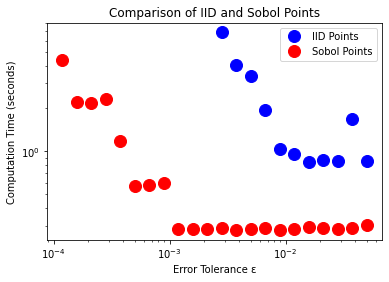

In [33]:
plt.loglog(xaxislist_iid, iids, 'bo', label='IID Points', markersize=12)
plt.loglog(xaxislist_sobol, sobols, 'ro', label='Sobol Points', markersize=12)
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.xlabel('Error Tolerance ε')
plt.ylabel('Computation Time (seconds)')
plt.title('Comparison of IID and Sobol Points')
plt.legend()
plt.show()